# Customer Segmentation Part III : Customer Clustering

## Topic

## Objective

## Summary

## Importing libraries

In [345]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,8)})

# Processing the data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Spliting data 
from sklearn.model_selection import train_test_split

from sklearn import datasets
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

## Importing the dataset

In [346]:
data = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Clients_Clustering\treated_ML.csv', sep =",")
data.head()

,order_status,est_act_shipp,shipping_duration,shipping_est_duration,quantity,price,freight_value,product_photos_qty,product_weight_g,product_volume_ltr,...,payment_value,review_score,seller_city,seller_state,customer_city,customer_state,product_category_name,limit_delivery_diff,Total_cost,total_revenue
0,delivered,44,22,66,1,69.99,23.36,1.0,1200.0,5984.0,...,653.64,2,sao paulo,SP,vilhena,RO,furniture_decor,-18,93.35,69.99
1,delivered,44,22,66,1,69.99,23.36,1.0,1200.0,5984.0,...,653.64,2,sao paulo,SP,vilhena,RO,furniture_decor,-18,93.35,69.99
2,delivered,44,22,66,1,280.00,84.96,1.0,4000.0,43680.0,...,653.64,2,sao paulo,SP,vilhena,RO,furniture_decor,-3,364.96,280.00
3,delivered,-1,19,18,1,112.00,11.44,3.0,1400.0,14036.0,...,123.44,2,sao paulo,SP,sao paulo,SP,furniture_decor,-15,123.44,112.00
4,delivered,10,10,20,1,284.90,44.22,4.0,20300.0,113652.0,...,329.12,4,sao paulo,SP,taubate,SP,furniture_decor,-5,329.12,284.90


In [347]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98109 entries, 0 to 98108
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_status           98109 non-null  object 
 1   est_act_shipp          98109 non-null  int64  
 2   shipping_duration      98109 non-null  int64  
 3   shipping_est_duration  98109 non-null  int64  
 4   quantity               98109 non-null  int64  
 5   price                  98109 non-null  float64
 6   freight_value          98109 non-null  float64
 7   product_photos_qty     98109 non-null  float64
 8   product_weight_g       98109 non-null  float64
 9   product_volume_ltr     98109 non-null  float64
 10  payment_sequential     98109 non-null  int64  
 11  payment_type           98109 non-null  object 
 12  payment_installments   98109 non-null  int64  
 13  payment_value          98109 non-null  float64
 14  review_score           98109 non-null  int64  
 15  se

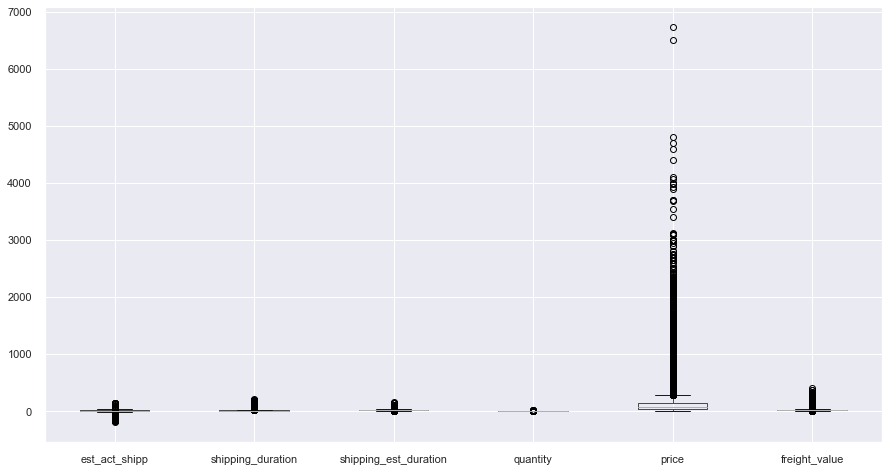

In [348]:
boxplots = data.boxplot(column=['est_act_shipp', 'shipping_duration', 'shipping_est_duration',
                               "quantity","price","freight_value"])

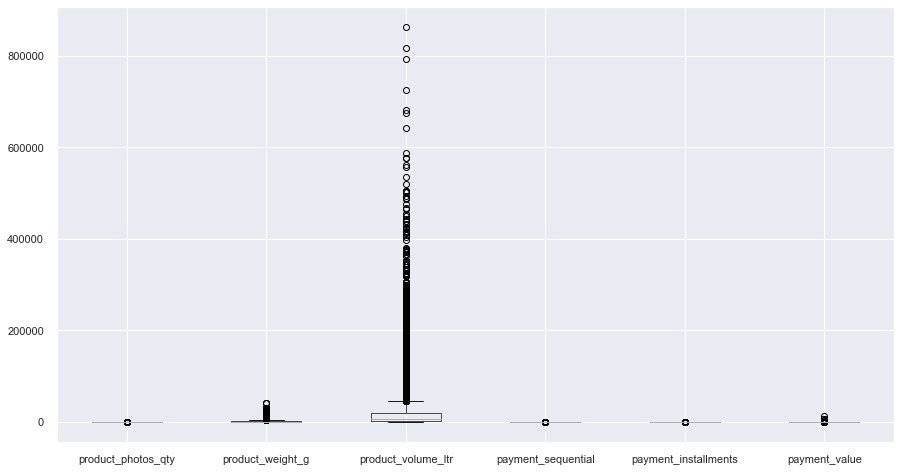

In [349]:
boxplots = data.boxplot(column=['product_photos_qty', 'product_weight_g', 'product_volume_ltr',
                               "payment_sequential","payment_installments","payment_value"])

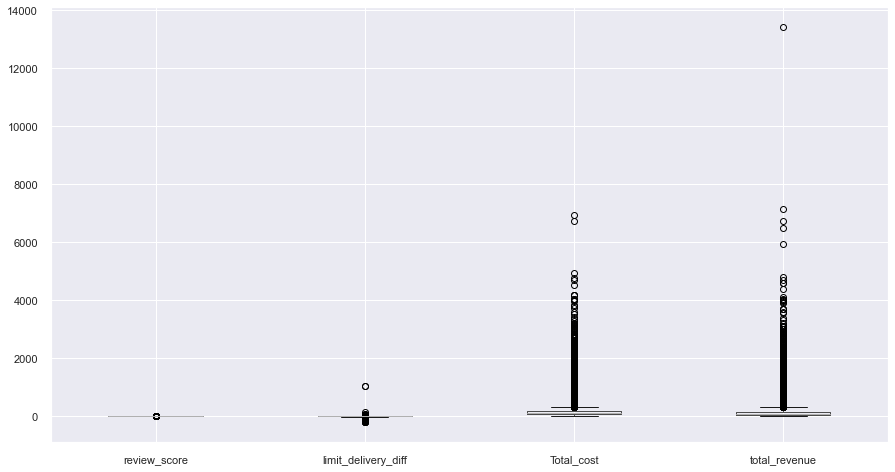

In [350]:
boxplots = data.boxplot(column=['review_score', 'limit_delivery_diff', 'Total_cost',
                               "total_revenue"])

Up to now, I've imported the dataset which contains numerical and categorical features, I ploted the box plots to take a look at outliers (because some of the clustering algorithms that I'm going to use are sensitive to outliers). We see that the features with the farthest outliers are total revenue, product volume and price. 

In [351]:
r = data["total_revenue"]
v = data["product_volume_ltr"]
p = data["price"]
n = data["product_category_name"]
d = pd.DataFrame()
d["total_revenue"] = r
d["product_volume_ltr"] = v
d["price"] = p
d["product_category_name"] = n
rev = d.sort_values(by="total_revenue", ascending=False)
rev.head()

,total_revenue,product_volume_ltr,price,product_category_name
15935,13440.0,32768.0,1680.0,fixed_telephony
15937,7160.0,25600.0,1790.0,fixed_telephony
3377,6735.0,120780.0,6735.0,housewares
96476,6499.0,29375.0,6499.0,art
97753,5934.6,50688.0,989.1,agro_industry_and_commerce


In [352]:
vol = d.sort_values(by="product_volume_ltr", ascending=False)
vol.head()

,total_revenue,product_volume_ltr,price,product_category_name
42498,1319.40,864000.0,219.90,computers_accessories
66587,1050.00,816480.0,175.00,signaling_and_security
67139,1559.92,793600.0,194.99,office_furniture
67429,1079.94,725760.0,179.99,office_furniture
53449,347.97,680943.0,115.99,cool_stuff


In [353]:
pri = d.sort_values(by="price", ascending =False)
pri.head()

,total_revenue,product_volume_ltr,price,product_category_name
3377,6735.0,120780.0,6735.0,housewares
96476,6499.0,29375.0,6499.0,art
50911,4799.0,88000.0,4799.0,small_appliances
50912,4690.0,122500.0,4690.0,small_appliances
96898,4590.0,14000.0,4590.0,computers


In the above part, I tried to dig a little deeper and see which products represent the outlying values. We see that the highest price was for a housewares product, the highest volume was for computer accessories products and the highest revenue of sale was for fixed telephony. All of these seem pretty logical and it's clear and they weren't recorded high by mistake.
So I won't replace them for now.

In [354]:
data.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

order_status                7
payment_type                4
seller_city                 2
seller_state                1
customer_city            4107
customer_state             27
product_category_name      71
dtype: int64

In [355]:
data = data.drop(["seller_state","seller_city","customer_city"], axis = 1)

Here I took a look at the number of categories each categorical feature has. Seller state has only one so I deleted it because it's no longer of any use. Seller city has 2 but they are both sao paulo (the accent is missing in some instances), so I deleted it too. Customer city on the other hand has a lot of categories. I also deleted customer city because it contains more than 4 thousand categories, and it'll take too long and charging to count all the zeros during one hot incoding.

## Splitting the train and test sets

In [356]:
train, test = train_test_split(data, test_size = 0.2,random_state = 42)

## Preparing data for ML 

In [357]:
# Seprating categircal features from numerical features
cat_train = train[["order_status","payment_type","customer_state","product_category_name"]].copy()
cat_test = test[["order_status","payment_type","customer_state","product_category_name"]].copy()

In [358]:
num_train = train.drop(["order_status","payment_type","customer_state","product_category_name"],axis=1)
num_test = test.drop(["order_status","payment_type","customer_state","product_category_name"],axis=1)

In [360]:
enc = OneHotEncoder()
sts = StandardScaler()
num_attr = list(num_train)
cat_attr = list(cat_train)
transform = ColumnTransformer([("num",sts,num_attr),("cat",enc,cat_attr)])
train_pre = transform.fit_transform(train)

In [361]:
num_attr = list(num_test)
cat_attr = list(cat_test)
transform = ColumnTransformer([("num",sts,num_attr),("cat",enc,cat_attr)])
test_pre = transform.fit_transform(test)

In [362]:
train = train_pre
test = test_pre

After splitting the dataset into train and test (80% train), I seperated the categorical features from the numerical ones to be able to build a transformation pipeline using Column Transformer, I used the standard scaler for num categories and onehot encoding for categorical features.

## Kmeans (Centroid-based clustering)

### Silhouette Plot